In [1]:
import torchvision.datasets as datasets
import torch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)

In [3]:
mnist_trainset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train

In [4]:
N = len(mnist_trainset)

In [5]:
mnist_trainset.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [6]:
mnist_trainset.data.shape

torch.Size([60000, 28, 28])

In [7]:
mnist_trainset.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

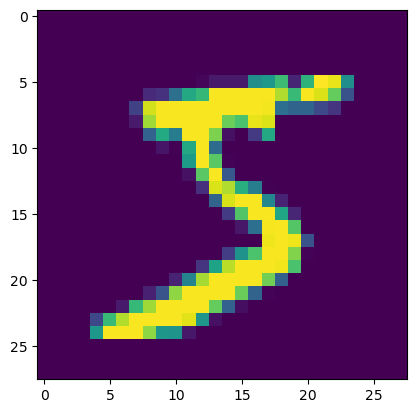

In [8]:
plt.imshow(mnist_trainset.data[0,:,:])
plt.show()

In [9]:
data_vec = torch.reshape(mnist_trainset.data, (60000, 28*28)).type(torch.double)

### Rather than estimating it directly using maximum likelihood, start by 
- estimating the data covariance matrix
- calculate the eigenvectors and eigenvalues
- to initialize 𝑊 (12.45)
- Then use eq 12.46 to calculate 𝜎

In [10]:
data_cov = torch.cov(data_vec.T)
data_eig = torch.linalg.eig(data_cov)
eig_vals = data_eig[0].real
eig_vecs = data_eig[1].real
#eig_vals = data_eig[0]
#eig_vecs = data_eig[1]

$W = U_M (L_M - \sigma^2 I)^{1/2}$  
U_M is DxM with columns being a subset of M eigenvectors of the covariance matrix.  
L_M is MxM diagonal with corresponding eigenvalues.  

In [11]:
D = data_eig.eigenvectors.shape[1]
M = 2
sig_sq = 1/(D-M)*torch.sum(eig_vals[2:])

In [12]:
U_M = eig_vecs[:,:2]
L_M = torch.diag(eig_vals[:2])

In [13]:
W = torch.matmul(U_M, (L_M-sig_sq*torch.eye(2))**0.5)

## 𝜇 is given by the population mean.

In [14]:
mu = torch.mean(data_vec, 0)

### Now evaluate and plot the expected value of z given x for all your input images.

$p(z|x) = N(z | M^{-1}W^T(x-\mu), \sigma^{-2}M)$  
$M = W^T W + \sigma^2 I$

In [15]:
mnist_test_set = datasets.MNIST(
    root='./data', train=False, download=True, transform=None)
test_vec = torch.reshape(
    mnist_test_set.data, (10000, 28*28)).type(torch.double)
#test_vec = data_vec
N_test = len(test_vec)

In [16]:
M_matrix = torch.matmul(W.T, W) + sig_sq * torch.eye(2)

In [17]:
x_mu = test_vec - mu

In [18]:
M_matrix_inv = torch.inverse(M_matrix)
temp = M_matrix_inv@W.T

In [19]:

z_loc = temp@x_mu.T
#z_loc = temp@x_mu.type(torch.complex128).T

### Color the points by the digit labels. Does the Probabilistic PCA latent space separate the 10 digits?

It is best at 0 and 1 the rest are more overlapping. But some tendencies are seen.

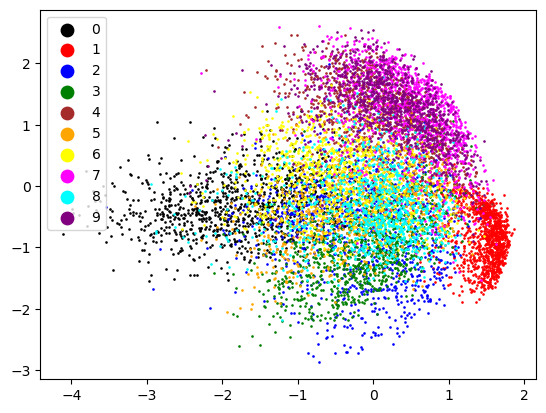

In [20]:
results_for_plot = z_loc.detach().numpy().T

scatter_x = results_for_plot[:,0]
scatter_y = results_for_plot[:,1]
group = mnist_test_set.targets
#group = mnist_trainset.targets
cdict = {0: 'black', 1: 'red', 2: 'blue', 3: 'green', 4: 'brown', 
         5: 'orange', 6: 'yellow', 7: 'magenta', 8: 'cyan', 9: 'purple'}

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 0.8)
ax.legend(markerscale = 10)
plt.show()

### compute log-likelihood of test set

In [21]:
pi = torch.tensor(np.pi)
C = W @ W.T + sig_sq * torch.eye(784)
_, C_det = torch.linalg.slogdet(C)
inverse_C = torch.inverse(C)
S = torch.cov(test_vec.T)
#S = torch.cov(test_vec.type(torch.complex128).T)
inner = D * torch.log(2*pi) + torch.trace(inverse_C @ S)
log_likelihood = -(N/2) * inner


In [22]:
log_likelihood

tensor(-66610432.9436, dtype=torch.float64)

### Sample latent variables z given test set samples x

In [23]:
from torch.distributions import Normal, MultivariateNormal

z_cov = sig_sq * M_matrix_inv
z_dist = MultivariateNormal(z_loc.T, z_cov)
z_samples = z_dist.sample()

### project latent variables to mean parameters of likelihood functions $P(x | z)$

In [24]:
x_mean = z_samples @ W.T + mu#.type(torch.complex64)

### Compare the mean parameters with corresponding test set images

C:\Users\Jacki\AppData\Local\Temp\ipykernel_3344\2020600511.py:1: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Copy.cpp:250.)
  x_mean_img = x_mean.reshape(-1, 28, 28).type(torch.double)


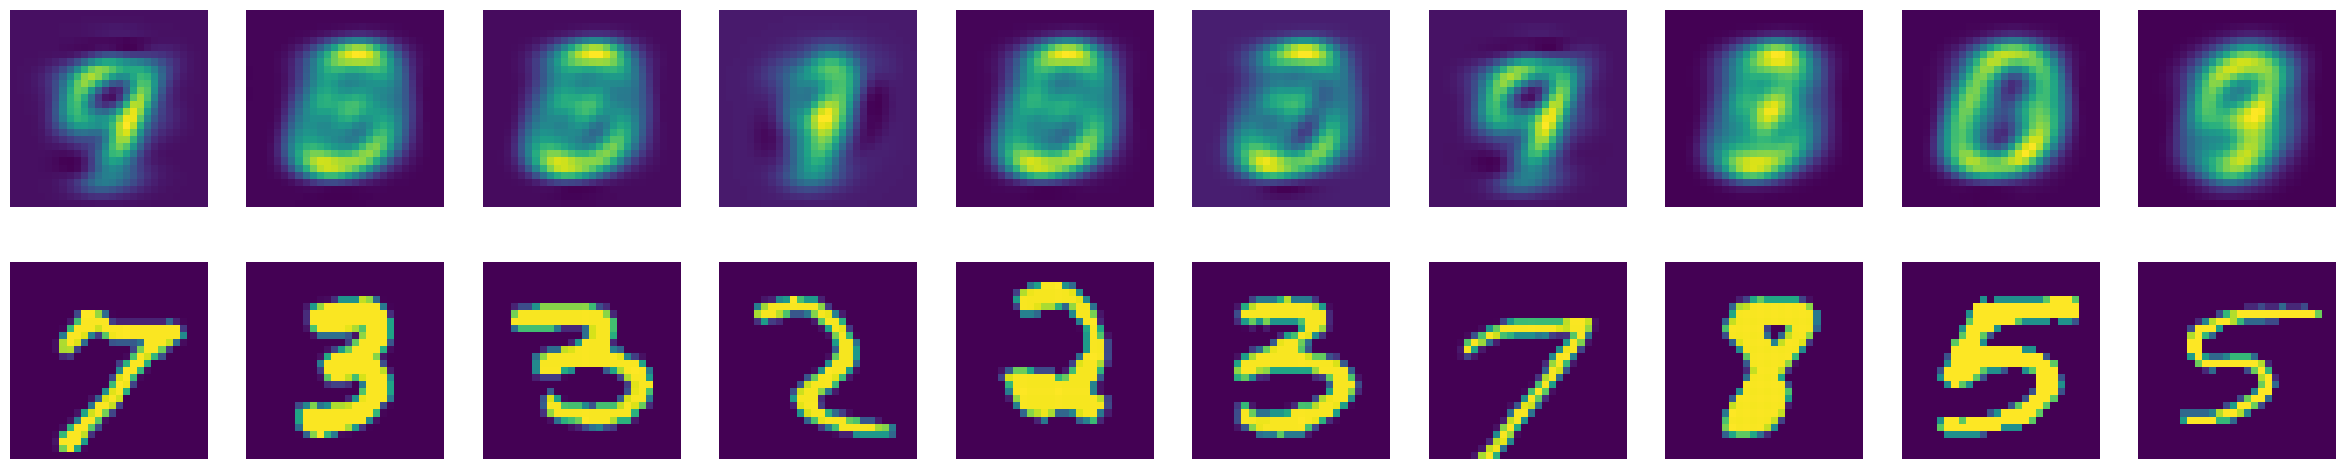

In [25]:
x_mean_img = x_mean.reshape(-1, 28, 28).type(torch.double)
test_img = test_vec.reshape(-1, 28, 28)
indices = torch.randperm(len(test_vec))[:10]
x_mean_img_sampled = x_mean_img[indices]
test_img_sampled = test_img[indices]
fig, ax = plt.subplots(nrows=2, ncols=10, figsize = (30, 6))
for j in range(10):
    ax[0][j].axis("off")
    ax[1][j].axis("off")
    ax[0][j].imshow(x_mean_img_sampled[j])
    ax[1][j].imshow(test_img_sampled[j])

### Sample reconstructions from the likelihood distributions
Note : as the likelihood distributions are isotropic gaussians we sample from them efficiently by simply sampling each value in a given feature dimension from an independent univariate gaussian distribution

In [26]:
x_normal = Normal(x_mean, sig_sq)
x_normal_samples = x_normal.sample()

### Compare sampled reconstructions with corresponding test set images

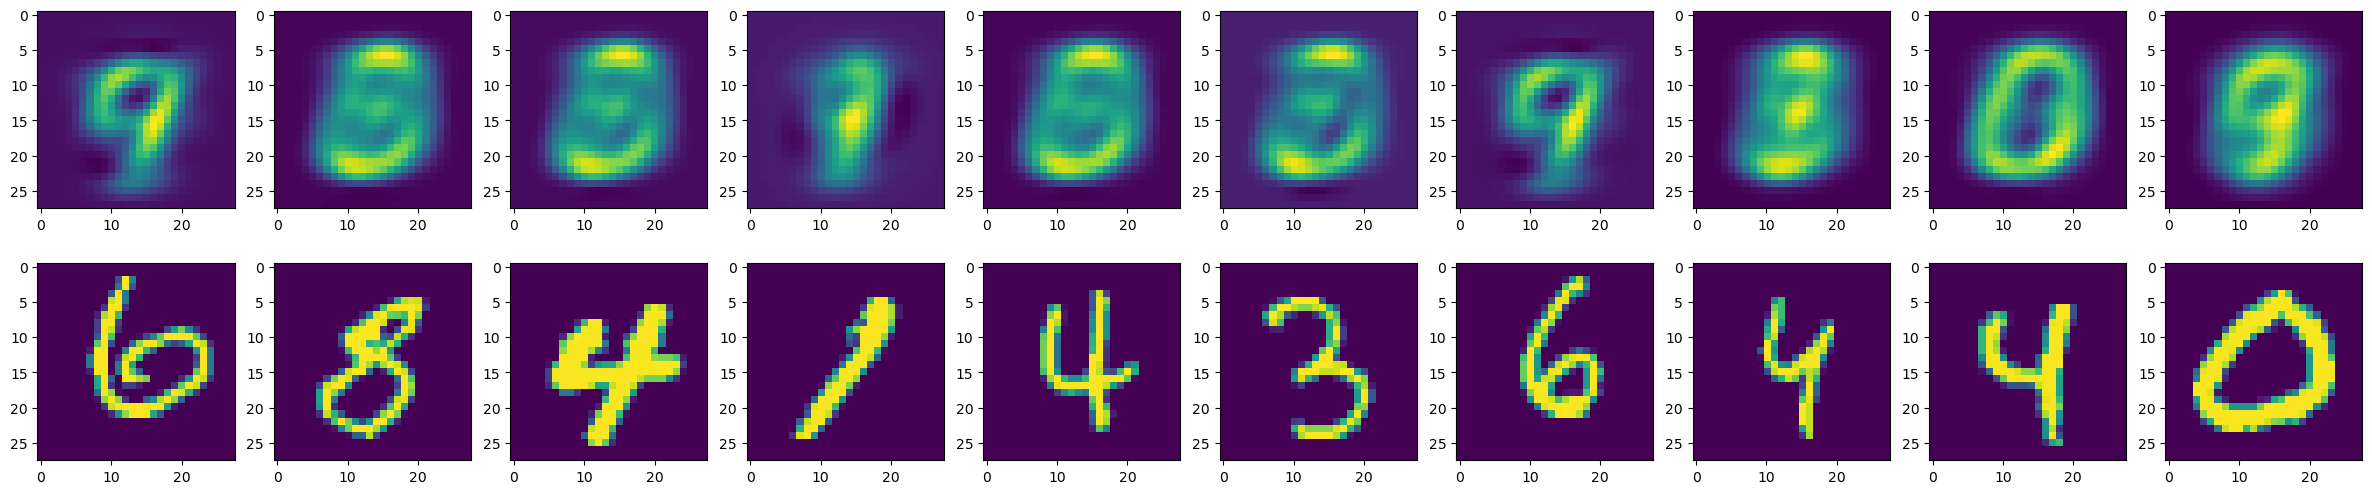

In [27]:
x_normal_samples_img = x_normal_samples.reshape(-1, 28, 28)
indices = torch.randperm(len(test_vec))[:10]
x_normal_samples_sampled = x_normal_samples[indices]
test_img_sampled = test_img[indices]
fig, ax = plt.subplots(nrows=2, ncols=10, figsize=(30, 6))
for j in range(10):
    ax[0][j].imshow(x_mean_img_sampled[j])
    ax[1][j].imshow(test_img_sampled[j])


### Compute the log likelihood from likelihood distributions (rather than analytically as before)
As both estimates of the log likelihood are on the same scale, they are probably both correct. The model simply has not been able to capture the variability of the mnist dataset very well. This is also what our earlier clustering graph indicates

In [28]:
log_probs_normal = x_normal.log_prob(test_vec)
log_prob_normal = log_probs_normal.sum().type(torch.double)
log_prob_normal

tensor(-71508047.3978, dtype=torch.float64)

### explore the latent space using a mesh grid and sample reconstructions $x$ from the corresponding likelihood distributions

In [29]:
M_steps = 12
x = torch.linspace(start=0, end=1, steps=M_steps+2)
x = x[:-1]
x = x[1:]

c:\Users\Jacki\anaconda3\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


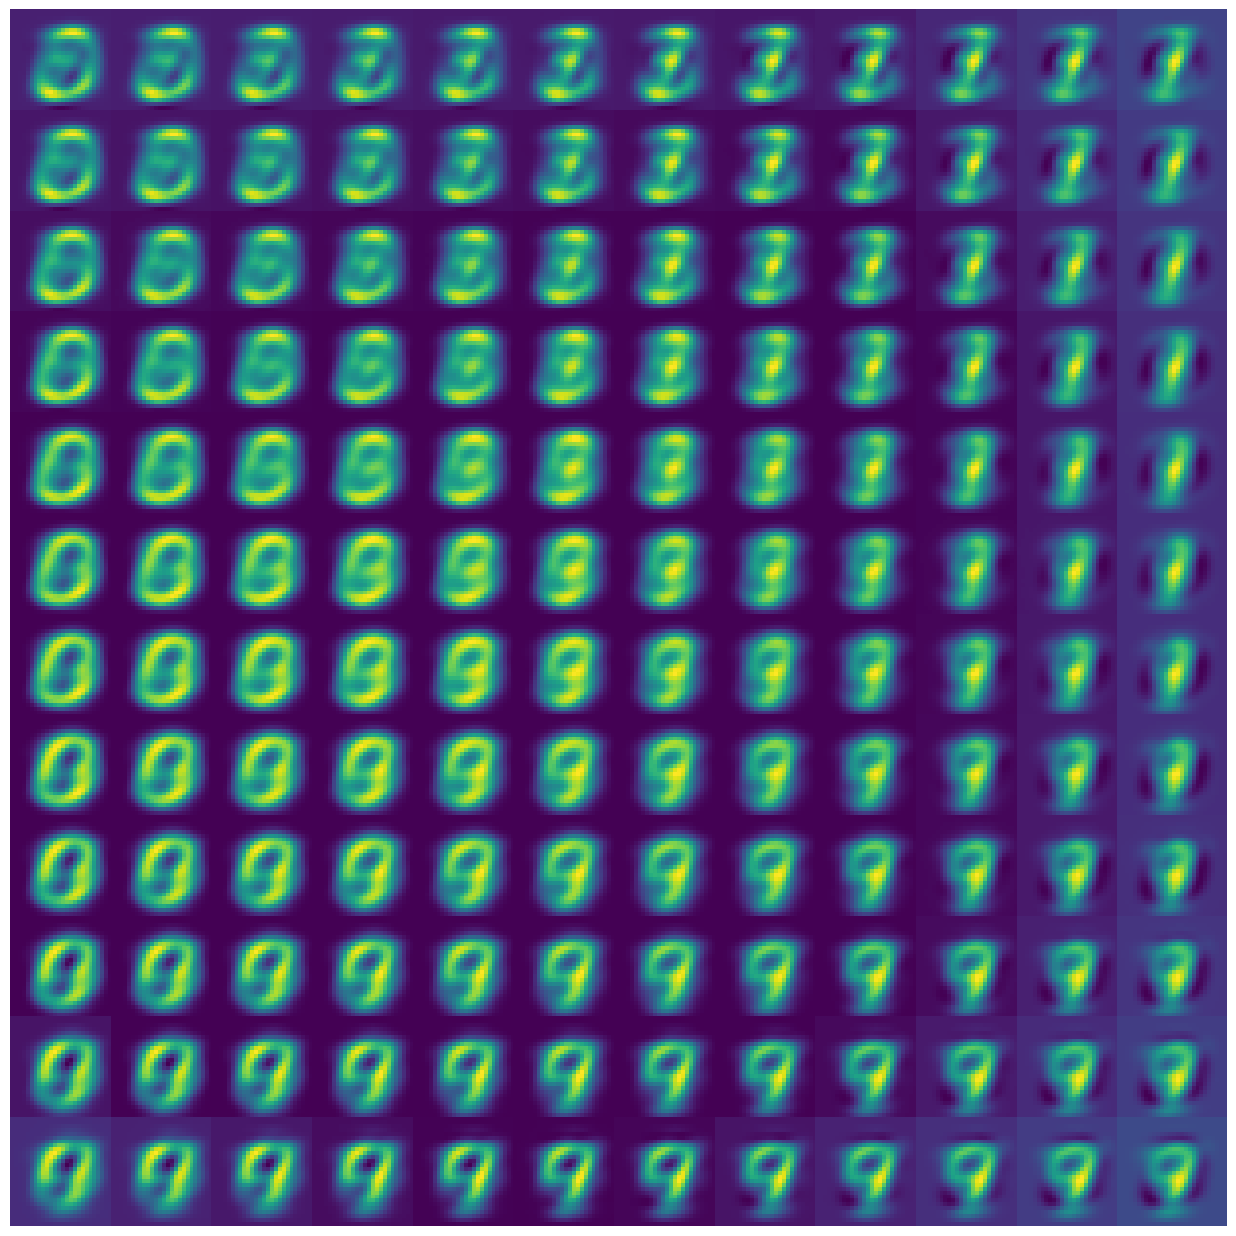

In [30]:
mesh_x, mesh_y = torch.meshgrid(x, x)
gauss = torch.distributions.normal.Normal(loc=0, scale=1)
gauss_x = gauss.icdf(mesh_x)  # .flip(0)
gauss_y = gauss.icdf(mesh_y)
fig, ax = plt.subplots(nrows=M_steps, ncols=M_steps, figsize=(12, 12),
                       sharex=True, sharey=True)
for i in range(M_steps):
    for j in range(M_steps):
        x_val = gauss_x[i, j].item()
        y_val = gauss_y[i, j].item()
        z_val = torch.tensor([y_val, x_val], dtype = torch.double)
        z_val_mean = z_val @ W.T + mu
        im_plt = z_val_mean.type(torch.double).reshape((28, 28))
        ax[i][j].imshow(im_plt)
        ax[i][j].axis("off")

slim = 0.6
plt.tight_layout(pad=-slim, w_pad=-slim, h_pad=-slim)
plt.show()


In [31]:
#x_mean_determ = z_loc @ W.T + mu.type(torch.complex64)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x10000 and 2x784)